<ipython-input-1-694253230944>:4: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.mitigation.measurement import (complete_meas_cal,


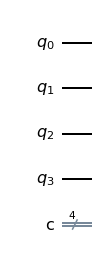

In [1]:
from qiskit import *
import numpy as np

from qiskit.ignis.mitigation.measurement import (complete_meas_cal,
                                                 CompleteMeasFitter, 
                                                 MeasurementFilter)
circuit = QuantumCircuit(4,4)
circuit.draw(output = 'mpl')

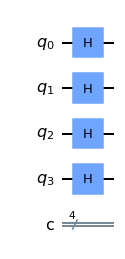

In [2]:
circuit.h([0,1,2,3])
circuit.draw(output = 'mpl')

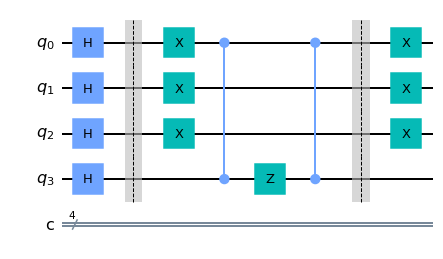

In [3]:
circuit.barrier()
circuit.x([0,1,2])
circuit.cz(0,3)
circuit.z([3])
circuit.cz(0,3)
circuit.barrier()
circuit.x([0,1,2])
circuit.draw(output = 'mpl')

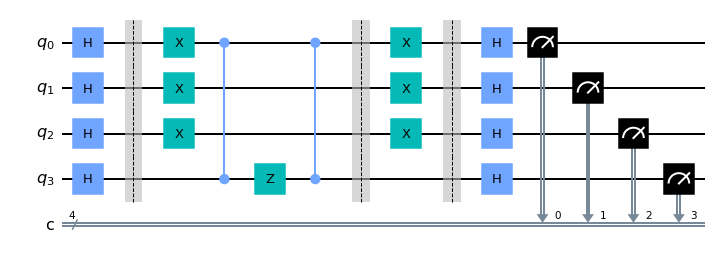

In [4]:
circuit.barrier()
circuit.h([0,1,2,3])
circuit.measure([0,1,2,3],[0,1,2,3])
circuit.draw(output = 'mpl')

In [5]:
simulator = Aer.get_backend('qasm_simulator')
result = execute(circuit, backend = simulator, shots = 100).result()
counts = result.get_counts()
print(counts)

{'1000': 100}


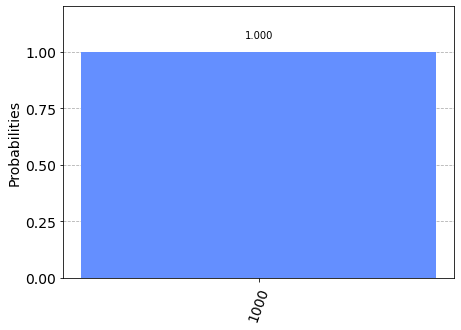

In [6]:
from qiskit.tools.visualization import plot_histogram

plot_histogram(counts)

In [7]:
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [8]:
provider = IBMQ.get_provider(hub='ibm-q')
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_extended_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_manila') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibm_nairobi') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibm_oslo

In [9]:
device = provider.get_backend('ibmq_manila')

In [10]:
device.status().to_dict()

{'backend_name': 'ibmq_manila',
 'backend_version': '1.0.33',
 'operational': True,
 'pending_jobs': 261,
 'status_msg': 'active'}

In [11]:
job = execute(circuit, backend = device, shots = 100)
print(job.job_id())
from qiskit.tools.monitor import job_monitor
job_monitor(job)

62b6013eb343f0fcba5f052b
Job Status: job has successfully run


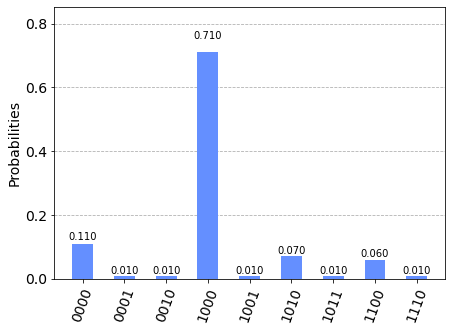

In [12]:
device_result = job.result()
plot_histogram(device_result.get_counts(circuit))

In [13]:
cal_circuits, state_labels = complete_meas_cal(qr = circuit.qregs[0], circlabel = 'measerrormitigationcal')
#qr = circuit.gregs[0] é um gravador quântico 
#circlabel = 'measerrormitig': é circuitos de calibração  mitigação de erros de medição.
#Ignis dá uma série de circuitos de calibração para executar e para descobrir quais são os erros ao executar cada um desses circuitos

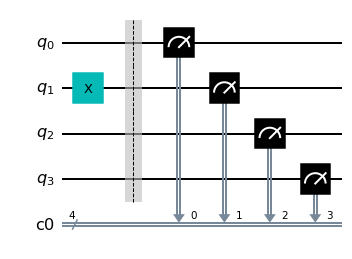

In [14]:
cal_circuits[2].draw(output='mpl')

In [15]:
len(cal_circuits) #quantidade de estados

16

In [16]:
#para calibrar
cal_job = execute(cal_circuits,
                 backend = device, #parâmetro que eu quero encontrar
                 shots = 100,
                 optimization_level = 0 #garante que circuitos não serão alterados na transferência daqui para o computador quântico real        
        )
print(cal_job.job_id())
job_monitor(cal_job)
cal_results = cal_job.result()

62b60e63b3f348f0d3f240dd
Job Status: job has successfully run


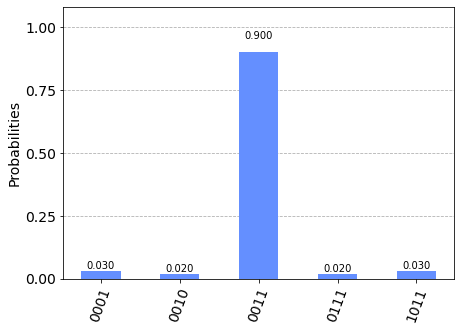

In [17]:
plot_histogram(
cal_results.get_counts(cal_circuits[3])
)

In [18]:
# Calculate the calibration matrix with the noise model
meas_fitter = CompleteMeasFitter(cal_results, state_labels)
print(meas_fitter.cal_matrix)


[[0.87 0.01 0.02 0.   0.15 0.   0.   0.   0.04 0.   0.   0.   0.   0.
  0.   0.  ]
 [0.04 0.9  0.   0.03 0.01 0.04 0.   0.01 0.01 0.05 0.   0.   0.   0.
  0.   0.  ]
 [0.   0.   0.89 0.02 0.01 0.   0.07 0.   0.   0.   0.02 0.   0.   0.
  0.   0.  ]
 [0.   0.03 0.02 0.9  0.   0.   0.   0.07 0.   0.   0.   0.03 0.   0.
  0.   0.  ]
 [0.05 0.   0.   0.   0.75 0.03 0.03 0.   0.   0.   0.   0.   0.05 0.
  0.01 0.  ]
 [0.   0.02 0.   0.   0.02 0.91 0.   0.02 0.   0.   0.   0.   0.   0.01
  0.   0.  ]
 [0.   0.   0.06 0.   0.02 0.   0.88 0.03 0.   0.   0.   0.   0.   0.
  0.03 0.  ]
 [0.   0.   0.   0.02 0.   0.01 0.01 0.85 0.   0.   0.   0.   0.   0.
  0.   0.02]
 [0.04 0.   0.   0.   0.   0.   0.   0.   0.92 0.02 0.03 0.   0.05 0.01
  0.01 0.  ]
 [0.   0.04 0.   0.   0.   0.   0.   0.   0.02 0.87 0.   0.04 0.   0.05
  0.   0.  ]
 [0.   0.   0.01 0.   0.   0.   0.   0.   0.   0.   0.92 0.04 0.   0.
  0.07 0.01]
 [0.   0.   0.   0.03 0.   0.   0.   0.   0.   0.03 0.   0.85 0.   0.
  0.   0.13

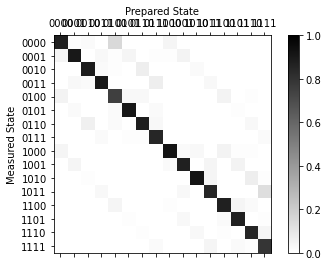

In [19]:
#Visualizar o conjunto  de resultados inteiros
meas_fitter.plot_calibration()

In [20]:
#filtro de medição
meas_filter = meas_fitter.filter

In [21]:
mitigated_result = meas_filter.apply(device_result)

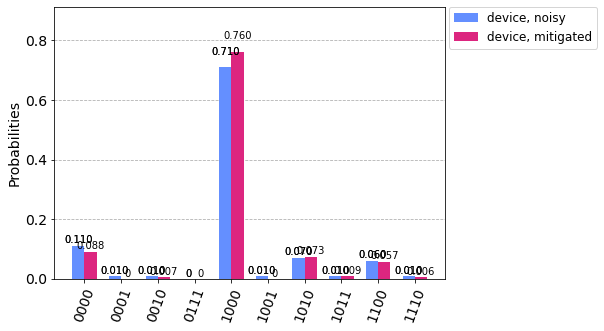

In [22]:
device_counts = device_result.get_counts(circuit)
mitigated_counts = mitigated_result.get_counts(circuit)
plot_histogram([device_counts, mitigated_counts], legend = ['device, noisy', 'device, mitigated'])